# Background and Overview
Music is an important part of people's lives and also a multi-billion dollar industry. However, with such a big industry there is always high interest and people seeking to break in and make it big. With a large number of music and new hits being created everyday, it becomes crucial to discern the best from the rest.

In this project we are exploring and proposing a machine learning approach to see which songs have what it takes to make it to billboard charts. We hope that this can give potential investors such as record labels to identify hit songs and promote that. To achieve that we have extract songs data from billboard charts and the vast library of spotify.

We perform following steps to obtain results (further elaborated in their own sections in the notebook)
1. Prepare Data for ML models
2. Descriptive Analysis
3. Train ML models(Logistic Regression, SVM and Random Forest)
4. Evaluate the models


---
Note: This notebook was created as a part of the project submission for 3253 - Machine Learning course.

Authors:
*   DAME JANKULOSKI
*   KRISTIN SKRITEK
*   NISHANTA KHANAL
*   VICTOR FONSECA
*   ZONAIR NADEEM


# 0.0. Environment

Here we just make sure all the modules and libraries that we want are properly imported and the required set-up steps are run.

In [ ]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from google.colab import drive

drive.mount('/content/drive', force_remount=True)

folder = "/content/drive/MyDrive/ML Group Project/Data Sets/" #data repository folder on Google drive

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

#ML models and metric libraries
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.svm import LinearSVC
from sklearn.metrics import hinge_loss, confusion_matrix, precision_recall_curve
from sklearn.metrics import classification_report, balanced_accuracy_score, roc_curve, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedShuffleSplit, GridSearchCV, RandomizedSearchCV

from sklearn.utils.class_weight import compute_class_weight

import os
from pprint import pprint

# to make this notebook's output stable across runs
np.random.seed(42)

Mounted at /content/drive


# 1.0. Prepare Data for ML models

The first step is to clean data for ML models. The dataset has a lot of features which includes information that we do not want to be fed into the model along with those we do. So, we need to make sure that we are selecting and feeding only the dataset that we deem are beneficial to the models. Furthermore, we can convert/map coded entries to their actual meaningful values for better readability.

## 1.1. Bring data together from various searches
Combination of the various web scraping data into one main data frame

In [ ]:
data = pd.read_csv(folder + "v2_with_genre.csv") \
  .merge(pd.read_csv(folder + "v4_release_dates.csv").drop("Unnamed: 0", axis=1),
         how="left", on='track_id')
  
data = data.dropna(subset=data.drop("release_date", axis=1).columns)
print(data.shape)
data = data[['track_id','title','artist_name','year',
             'release_year','release_month','release_day','release_week',
             'billboard','danceability','duration_ms','energy','instrumentalness',
             'key','liveness','loudness','mode','number','popularity','speechiness',
             'tempo','time_signature','acousticness','valence','genres']]
data = data.dropna(subset=data.drop("genres", axis=1).columns)
print(data.shape)

(531559, 32)
(531559, 25)


## 1.2. Categorical features Mode and Key converted back

In [ ]:
#Convert two features mode and key to ther categorical
data.loc[data["mode"]==0, "mode"] = "Minor"
data.loc[data["mode"]==1, "mode"] = "Major"
data.loc[data["key"]==0, "key"] = "C"
data.loc[data["key"]==1, "key"] = "C#/D♭"
data.loc[data["key"]==2, "key"] = "D"
data.loc[data["key"]==3, "key"] = "D#/E♭"
data.loc[data["key"]==4, "key"] = "E"
data.loc[data["key"]==5, "key"] = "F"
data.loc[data["key"]==6, "key"] = "F#/G♭"
data.loc[data["key"]==7, "key"] = "G"
data.loc[data["key"]==8, "key"] = "G#/A♭"
data.loc[data["key"]==9, "key"] = "A"
data.loc[data["key"]==10, "key"] = "A#/B♭"
data.loc[data["key"]==11, "key"] = "B"
data.loc[data["time_signature"].isin([3,4])==False,"time_signature"] = "Other/NA"


In [ ]:
data.drop_duplicates(['title', 'artist_name'], keep='first', inplace=True)
print(data.shape)
# data[data["title"]=="A Sky Full of Stars"]
# data[data["title"]=="Your Love Is My Drug"]
# data[data["title"]=="Natures Music : Waves"]
# data["title+artist_name"] = data['title']+"/"+data['artist_name']
# data["title+artist_name"].value_counts(ascending=False)
# data["title+artist_name+year"] = data['title']+"/"+data['artist_name']+"/"+data["release_year"].astype(str)
# data["title+artist_name+year"].value_counts(ascending=False)

pd.crosstab(data["year"], data["billboard"])

(449671, 25)


billboard,0,1
year,,
2009,37751,100
2010,39123,86
2011,37804,88
2012,37005,92
2013,37004,89
2014,37053,89
2015,39104,90
2016,39397,86
2017,39844,90


In [ ]:
top_names = data["title"].value_counts(ascending=False).reset_index()
# top_names.head(100).tail(50)
data = data[(data["title"]!="?") &
            (data["title"]!="...") &
            (data["title"]!="???") &
            (data["title"]!=".") &
            (data["title"]!="!") &
            (data["title"]!="_") &
            (data["title"]!="*") &
            (data["title"]!="~") &
            (data["title"]!="$") &
            (data["title"]!="$$$") &
            (data["title"]!=" ")]
top_names = data["title"].value_counts(ascending=False).reset_index()
top_names.head(50)

In [ ]:
genres = data["genres"].value_counts(ascending=False).reset_index()
# genres[genres["index"].str.contains("classical")].head(50)
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("classical")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("karaoke")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("hoerspiel")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("reading")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("bible")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("sleep")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("lesen")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("sound")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("sound effects")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("environmental")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("white noise")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("classify")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("asmr")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("ballet class")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("background music")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("halloween")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("workout product")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("pianissimo")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("drama")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("musica de fondo")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("pet calming")==False))]
data = data[(data["billboard"]==1) | ((data["billboard"]==0) & (data["genres"].str.contains("cover")==False))]
pd.crosstab(data["year"], data["billboard"])

billboard,0,1
year,,
2009,27461,100
2010,29522,86
2011,29653,88
2012,29915,92
2013,30730,89
2014,30797,89
2015,32444,90
2016,33037,86
2017,34586,90


In [ ]:
genres = data["genres"].value_counts(ascending=False).reset_index()
genres.head(50)

,index,genres
0,k-pop_k-pop boy group,2079
1,otacore,1280
2,contemporary country_country_country road_mode...,1253
3,chillhop_lo-fi beats,1231
4,classic rock_cosmic american_country rock_doub...,1120
5,children's music,1028
6,lo-fi beats,1019
7,k-pop_k-pop girl group,992
8,scorecore,860
9,lullaby,828


In [ ]:
data["pop"] = data["genres"].str.contains("pop")
data["rock"] = data["genres"].str.contains("rock")
data["rap"] = data["genres"].str.contains("rap")
data["hip hop"] = data["genres"].str.contains("hip hop")
data["country"] = data["genres"].str.contains("country")
data["k-pop"] = data["genres"].str.contains("k-pop")
data["children"] = data["genres"].str.contains("children")
data["dance"] = data["genres"].str.contains("dance")
data["electronic"] = data["genres"].str.contains("electronic")
data["alternative"] = data["genres"].str.contains("alternative")
data["acoustic"] = data["genres"].str.contains("acoustic")
data["edm"] = data["genres"].str.contains("edm")
data["latin"] = data["genres"].str.contains("latin")
data["reggae"] = data["genres"].str.contains("reggae")
data["folk"] = data["genres"].str.contains("folk")
data["modern"] = data["genres"].str.contains("modern")
data["blues"] = data["genres"].str.contains("blues")
data["jazz"] = data["genres"].str.contains("jazz")
data["soul"] = data["genres"].str.contains("soul")
data["r&b"] = data["genres"].str.contains("r&b")
pd.crosstab(data["year"], data["billboard"])

billboard,0,1
year,,
2009,27461,100
2010,29522,86
2011,29653,88
2012,29915,92
2013,30730,89
2014,30797,89
2015,32444,90
2016,33037,86
2017,34586,90


In [ ]:
# data.drop(["title+artist_name","title+artist_name+year"], axis=1, inplace=True)
data.head()

,track_id,title,artist_name,year,release_year,release_month,release_day,release_week,billboard,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,number,popularity,speechiness,tempo,time_signature,acousticness,valence,genres,pop,rock,rap,hip hop,country,k-pop,children,dance,electronic,alternative,acoustic,edm,latin,reggae,folk,modern,blues,jazz,soul,r&b
0,7xRNsqOQOgWbHV1nbXnfXN,Boom Boom Pow,Black Eyed Peas,2009,2009,1,1,1,1,0.867,251440,0.857,0.001710,A,0.130,-5.892,Major,1,64,0.0663,130.048,4,0.13000,0.402,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,4vp2J1l5RD4gMZwGFLfRAu,I Gotta Feeling,Black Eyed Peas,2009,2009,1,1,1,1,0.743,289133,0.766,0.000000,C,0.509,-6.375,Major,4,73,0.0265,127.960,4,0.08730,0.610,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,5OiLJ8tjUPFiPX2gVM8fxJ,Imma Be,Black Eyed Peas,2010,2009,1,1,1,1,0.597,257560,0.517,0.000000,C,0.307,-6.963,Major,20,64,0.3650,92.035,4,0.17900,0.412,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
6,0xfpx7AiwgSKEtjotea2L6,Meet Me Halfway,Black Eyed Peas,2010,2009,1,1,1,1,0.798,284373,0.629,0.000022,B,0.324,-6.857,Minor,58,62,0.0735,130.000,4,0.00474,0.400,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
8,5K5LbSTVuKKe1KGMNfBgIW,Rock That Body,Black Eyed Peas,2010,2009,1,1,1,1,0.715,268840,0.907,0.000084,G,0.426,-6.025,Minor,75,56,0.0993,124.992,4,0.01720,0.841,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
billboard_agg = pd.pivot_table(data,
               values='billboard',
               index='artist_name',
               columns='year',
               aggfunc=max,
               fill_value=0)
for i in billboard_agg:
    billboard_agg[i] = billboard_agg.loc[:, :i].max(axis=1)
billboard_agg = billboard_agg.unstack().reset_index()
billboard_agg["year"] = billboard_agg["year"]+1
billboard_agg.columns = ["year","artist_name","ever been on billboard"]
billboard_agg[(billboard_agg["artist_name"]=="will.i.am")]
data = data.merge(billboard_agg, how="left", on=["year","artist_name"])
data["ever been on billboard"].fillna(0, inplace=True)
data.head()

,track_id,title,artist_name,year,release_year,release_month,release_day,release_week,billboard,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,number,popularity,speechiness,tempo,time_signature,acousticness,valence,genres,pop,rock,rap,hip hop,country,k-pop,children,dance,electronic,alternative,acoustic,edm,latin,reggae,folk,modern,blues,jazz,soul,r&b,ever been on billboard
0,7xRNsqOQOgWbHV1nbXnfXN,Boom Boom Pow,Black Eyed Peas,2009,2009,1,1,1,1,0.867,251440,0.857,0.001710,A,0.130,-5.892,Major,1,64,0.0663,130.048,4,0.13000,0.402,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0.0
1,4vp2J1l5RD4gMZwGFLfRAu,I Gotta Feeling,Black Eyed Peas,2009,2009,1,1,1,1,0.743,289133,0.766,0.000000,C,0.509,-6.375,Major,4,73,0.0265,127.960,4,0.08730,0.610,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0.0
2,5OiLJ8tjUPFiPX2gVM8fxJ,Imma Be,Black Eyed Peas,2010,2009,1,1,1,1,0.597,257560,0.517,0.000000,C,0.307,-6.963,Major,20,64,0.3650,92.035,4,0.17900,0.412,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,1.0
3,0xfpx7AiwgSKEtjotea2L6,Meet Me Halfway,Black Eyed Peas,2010,2009,1,1,1,1,0.798,284373,0.629,0.000022,B,0.324,-6.857,Minor,58,62,0.0735,130.000,4,0.00474,0.400,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,1.0
4,5K5LbSTVuKKe1KGMNfBgIW,Rock That Body,Black Eyed Peas,2010,2009,1,1,1,1,0.715,268840,0.907,0.000084,G,0.426,-6.025,Minor,75,56,0.0993,124.992,4,0.01720,0.841,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,1.0


## 1.3. Output Dataset to CSV for ML Models to be done separately

Comment out this line if only portion of code is to be done

In [ ]:
#data.to_csv(folder + "DataSet_main.csv", index=None)

# 2.0. Descriptive Analytics

This section can be done independent of the ML Modelling and is to be used to gain insight into the data set and features used

In [ ]:
data = pd.read_csv(folder + "DataSet_main.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 360738 entries, 0 to 360737
Data columns (total 46 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   track_id                360738 non-null  object 
 1   title                   360738 non-null  object 
 2   artist_name             360738 non-null  object 
 3   year                    360738 non-null  int64  
 4   release_year            360738 non-null  int64  
 5   release_month           360738 non-null  int64  
 6   release_day             360738 non-null  int64  
 7   release_week            360738 non-null  int64  
 8   billboard               360738 non-null  int64  
 9   danceability            360738 non-null  float64
 10  duration_ms             360738 non-null  int64  
 11  energy                  360738 non-null  float64
 12  instrumentalness        360738 non-null  float64
 13  key                     360738 non-null  object 
 14  liveness            

### 2.1. Data Pipeline Definition

In [ ]:
num_features = ['danceability','duration_ms','energy','instrumentalness',
                'liveness','loudness','speechiness','tempo','acousticness','valence']
cat_features = ['release_year','release_month','release_day','release_week',
                'key','mode','time_signature','pop', 'rock','rap','hip hop','country',
                'k-pop','children','dance','electronic','alternative','acoustic',
                'edm','latin','reggae','folk','modern','blues','jazz','soul','r&b']
remaining_features = ['track_id','title','artist_name','year','number','popularity','genres','billboard']
styles = ['pop', 'rock','rap','hip hop','country','k-pop','children','dance',
          'electronic','alternative','acoustic','edm','latin','reggae','folk',
          'modern','blues','jazz','soul','r&b']

label = 'billboard'



num_pipeline = Pipeline([
                         ('std_scaler', StandardScaler())
                         ])
full_pipeline = ColumnTransformer([
                                   ("num", num_pipeline, num_features),
                                   ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features) 
                                   ])



### 2.2. Read Data and Transform

In [ ]:
data = pd.read_csv(folder + "DataSet_main.csv")
data.info()

In [ ]:
X = data.drop(remaining_features, axis=1)
X_pipeline = full_pipeline.fit_transform(X)

In [ ]:
X.shape, X_pipeline.shape

((360738, 38), (360738, 180))

###2.3. Features per class grouping

In [ ]:
data.drop(remaining_features, axis=1).groupby("billboard").mean().transpose()

billboard,0,1
release_year,2014.430252,2013.719917
release_month,6.376500,5.670124
release_day,14.178179,13.137967
release_week,28.958740,25.981328
danceability,0.574163,0.663109
duration_ms,238627.531855,223291.672199
energy,0.627343,0.683080
instrumentalness,0.170215,0.005520
liveness,0.225923,0.174021
loudness,-8.385215,-5.633783


###2.4. Numerical Features plot

In [ ]:
sns.set_theme(style="ticks")
sns.pairplot(data[num_features])

Output hidden; open in https://colab.research.google.com to view.

###2.5. Distribution of Numerical Features

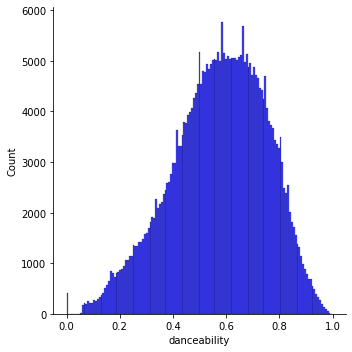

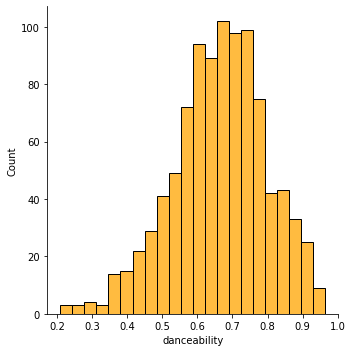

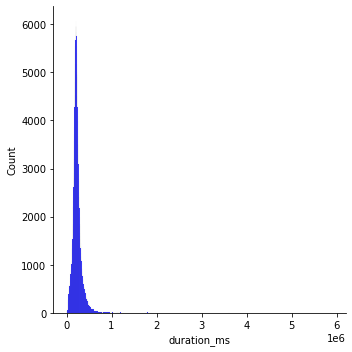

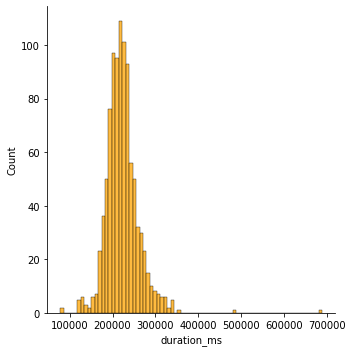

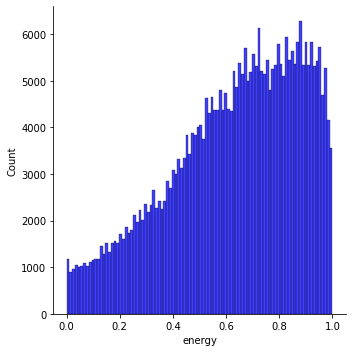

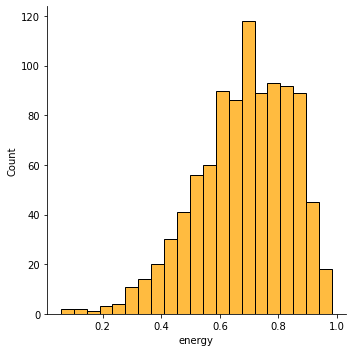

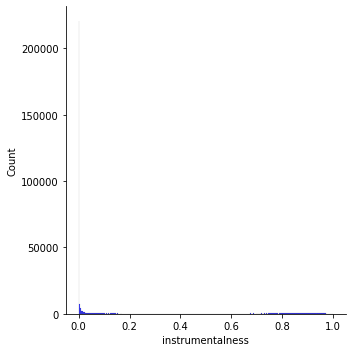

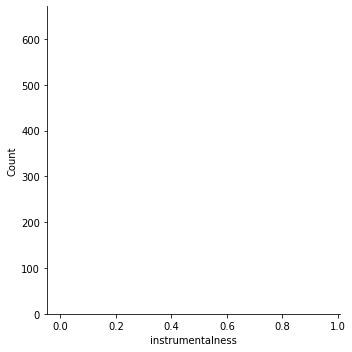

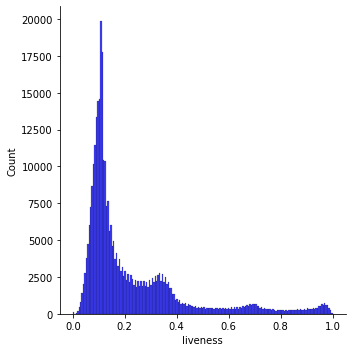

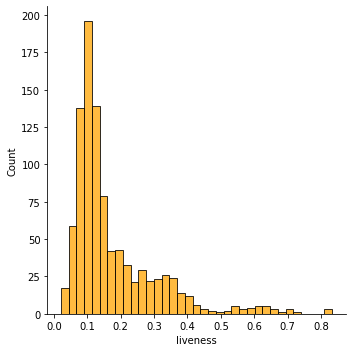

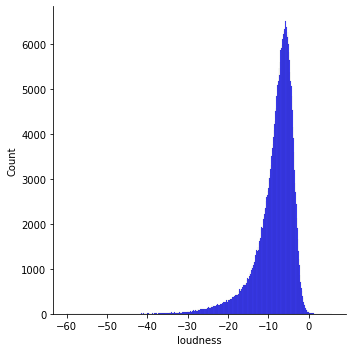

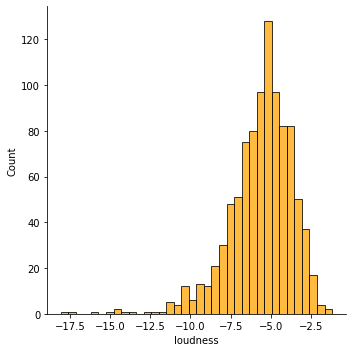

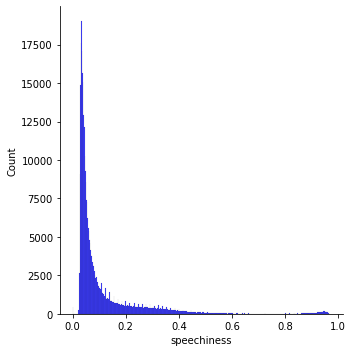

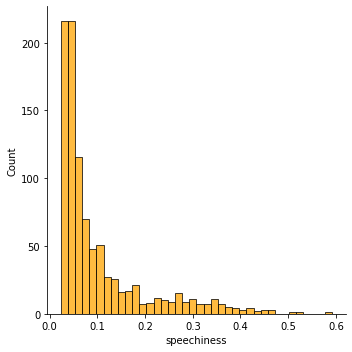

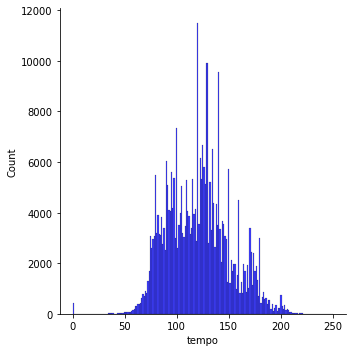

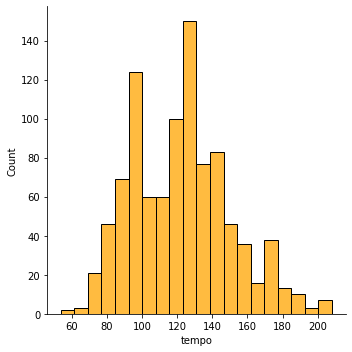

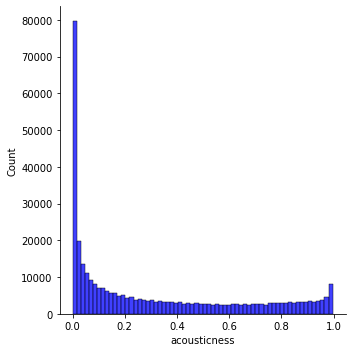

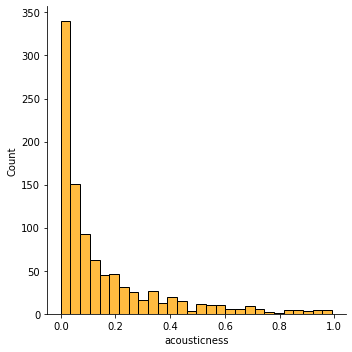

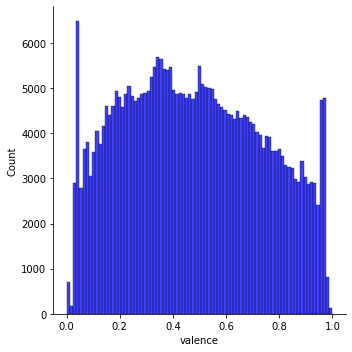

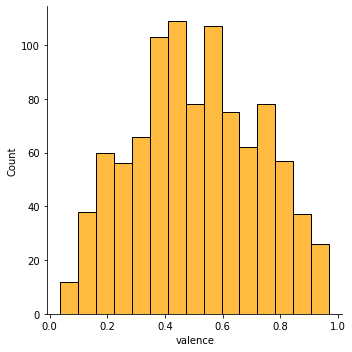

In [ ]:
billboard = data[data[label]==1]
non_billboard = data[data[label]==0]
for num in num_features:
  sns.displot(non_billboard, x=num, color="blue")
  sns.displot(billboard, x=num, color="orange")

###2.6. Distribution of Categorical Features

In [ ]:
for cat in list(set(cat_features)-set(styles)):
  data[cat].value_counts().plot(kind="bar", title=cat)
  plt.show()

###2.7. Song Style/Genre Distribution 

In [ ]:
for style in styles:
  print(style)
  data[["billboard",style]].groupby("billboard").mean().transpose().plot(kind="bar")
  plt.show()

###2.8. Features Heat Map 

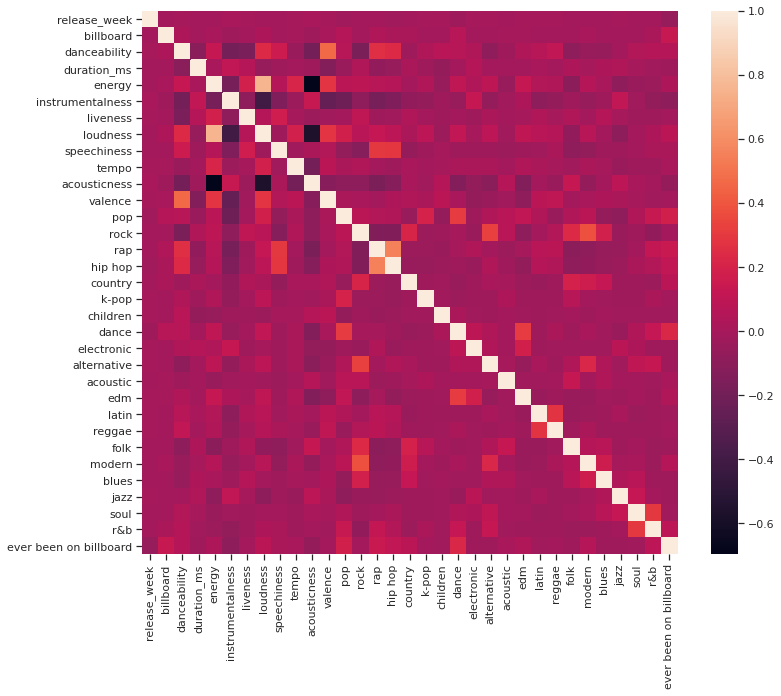

In [ ]:
f, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(data.drop(remaining_features, axis=1).drop(["release_year", "release_month", "release_day"], axis=1).corr(), ax=ax)

###2.9. Yearly Trends for Features

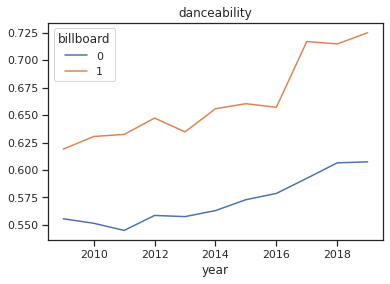

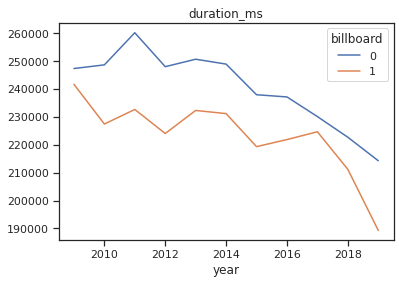

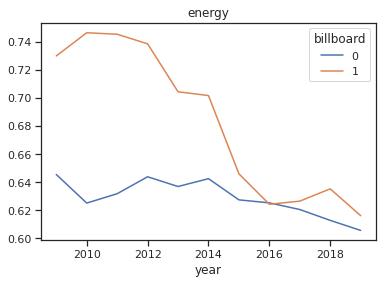

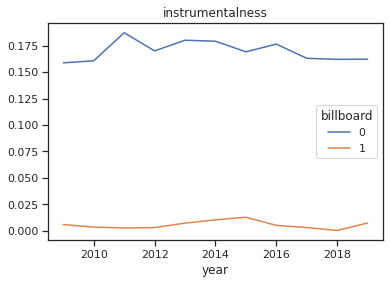

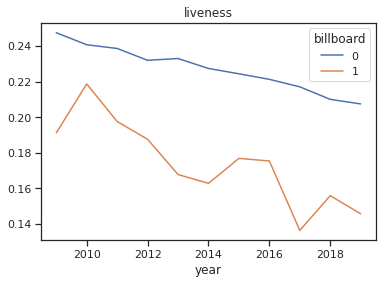

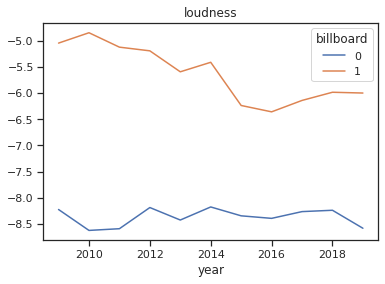

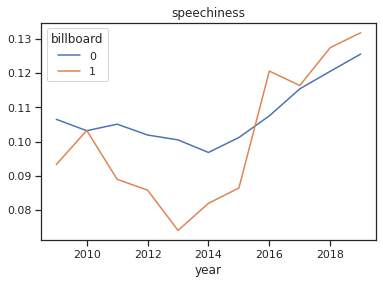

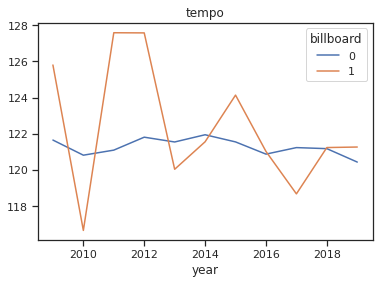

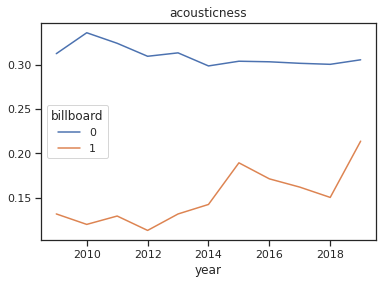

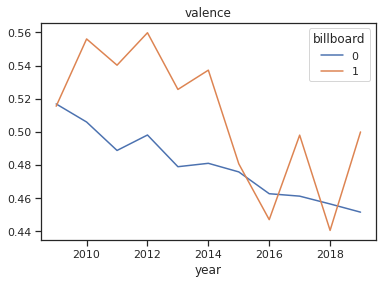

In [ ]:
for feat in num_features:
    pd.pivot_table(data[data["year"]<2020],
                   values=feat,
                   index='year',
                   columns='billboard',
                   aggfunc=np.mean).plot(title=feat)

#3.0. ML Models

**These are the 3 different models we evaluated against the spotify and billboard data set**

##3.1. Helper Functions

###3.1.1. Logistic Regression Evaluation Function
This function is used to generate the various ML model metrics for logistic regression

In [ ]:
def log_reg_eval(X_train_tf, X_test_tf,y_train,y_test,adj_weight=False):

  weighting=[1,1]
  if adj_weight:
    weighting = compute_class_weight('balanced', [0,1], y_train)

  ml_estimator = LogisticRegression(max_iter=1000, C=10**10, class_weight=weighting)
  ml_estimator.fit(X_train_tf, y_train)

  print("Class Weights: ", ml_estimator.class_weight)

  y_pred = ml_estimator.predict(X_test_tf)
  y_pred_prob = ml_estimator.predict_proba(X_test_tf)

  ml_score = ml_estimator.score(X_test_tf,y_test)
  baseline = 1 - len(y[y==1])/len(y)

  print("Classification Report")
  print("====")
  print(classification_report(y_test, y_pred))
  print("====")

  print("Metrics")
  print("====")
  print("Score: \t\t", ml_score)
  print("Do Nothing: \t", baseline)
  print("====")

  print("Confusion Matrix")
  print("====")
  print(confusion_matrix(y_test, y_pred))
  print("====")

  print("ROC Curve")
  print("====")
  plot_roc_curve(ml_estimator, X_test_tf, y_test, name="ROC Curve")
  plt.plot([0, 1], [0, 1], 'k--') 
  plt.show()

  y_scores = ml_estimator.decision_function(X_test_tf)

  precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
 
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
  
  recall_ml_precision = recalls[np.argmax(precisions >= ml_score)]
  threshold_ml_precision = thresholds[np.argmax(precisions >= ml_score)]

  plt.plot([threshold_ml_precision], [recall_ml_precision], 'go')
  plt.plot([threshold_ml_precision], [ml_score], 'bo')
  plt.legend(loc="center right", fontsize=16)
  plt.xlabel("Threshold", fontsize=12)
  plt.ylim(-.01, 1.01)
  plt.title("Logistic Regression")
  plt.grid(True)
  print("====")

  print("Precision vs Recall")
  print("====")
  plt.show()

  plt.title("Recall vs Precision",fontsize=20)
  plt.plot(recalls[:-1],precisions[:-1])
  plt.xlabel("Recall",fontsize=16)
  plt.ylabel("Precision",fontsize=16)
  plt.show()

  print("====")

  return ml_estimator

###3.1.2. Learning Curve Function

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

##3.2. Re-read Data
Use this section of code if data needs to be re-read due to notebook restart etc.

In [ ]:
data = pd.read_csv(folder + "DataSet_main.csv")
data = data[data["year"]<2020]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 345403 entries, 0 to 359005
Data columns (total 46 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   track_id                345403 non-null  object 
 1   title                   345403 non-null  object 
 2   artist_name             345403 non-null  object 
 3   year                    345403 non-null  int64  
 4   release_year            345403 non-null  int64  
 5   release_month           345403 non-null  int64  
 6   release_day             345403 non-null  int64  
 7   release_week            345403 non-null  int64  
 8   billboard               345403 non-null  int64  
 9   danceability            345403 non-null  float64
 10  duration_ms             345403 non-null  int64  
 11  energy                  345403 non-null  float64
 12  instrumentalness        345403 non-null  float64
 13  key                     345403 non-null  object 
 14  liveness            

##3.3 Train-Test Split and Features Transformation

In [ ]:
X=data.drop(remaining_features,axis=1)
y=data[label]

X_train, X_test, y_train, y_test = train_test_split(X, y)

fp = full_pipeline.fit(X_train)
X_train_tf = fp.transform(X_train)
X_test_tf = fp.transform(X_test)

In [ ]:
X_train.shape, X_train_tf.shape, y_train.shape, y_test.shape

((259052, 38), (259052, 180), (259052,), (86351,))

##3.4. Model 1 - Logistic Regression
Evaluate the different hyperparameter options and compare results

###3.4.1 No class weights

Full dataset - No Class weight

Class Weights:  [1, 1]
Classification Report
====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     86104
           1       1.00      0.05      0.10       247

    accuracy                           1.00     86351
   macro avg       1.00      0.53      0.55     86351
weighted avg       1.00      1.00      1.00     86351

====
Metrics
====
Score: 		 0.9972901298189946
Do Nothing: 	 0.9971482587007061
====
Confusion Matrix
====
[[86104     0]
 [  234    13]]
====
ROC Curve
====


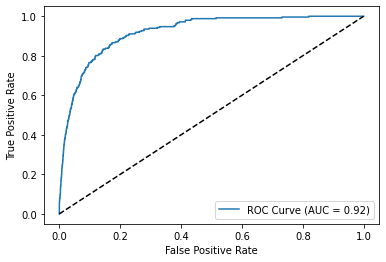

====
Precision vs Recall
====


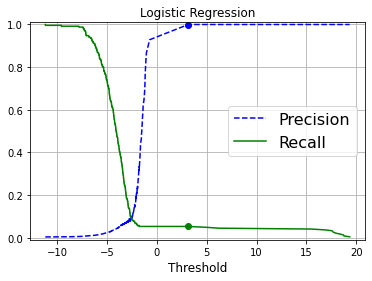

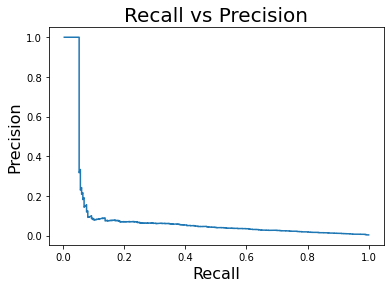

====


In [ ]:
print("Full dataset - No Class weight\n")
log_reg = log_reg_eval(X_train_tf,X_test_tf,y_train,y_test)

###3.4.2. Adjusting Class weights

Full dataset - Adjust Class weight



/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:856: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if class_weight == "balanced":


Class Weights:  [  0.50142849 175.50948509]
Classification Report
====
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     86104
           1       1.00      0.05      0.10       247

    accuracy                           1.00     86351
   macro avg       1.00      0.53      0.55     86351
weighted avg       1.00      1.00      1.00     86351

====
Metrics
====
Score: 		 0.9972901298189946
Do Nothing: 	 0.9971482587007061
====
Confusion Matrix
====
[[86104     0]
 [  234    13]]
====
ROC Curve
====


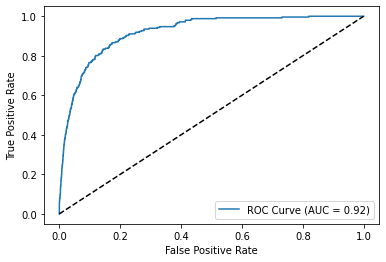

====
Precision vs Recall
====


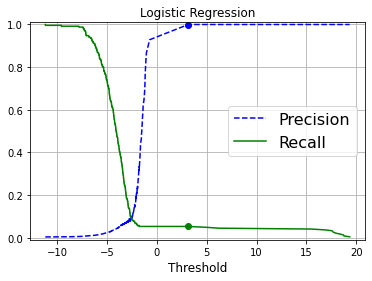

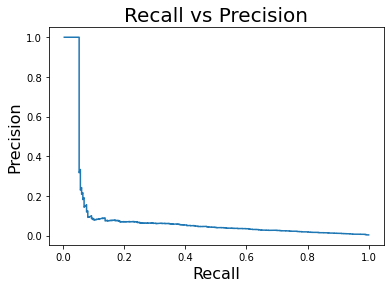

====


In [ ]:
print("Full dataset - Adjust Class weight\n")
log_reg = log_reg_eval(X_train_tf,X_test_tf,y_train,y_test,adj_weight=True)

###3.4.3. Learning Curve Plot

In [ ]:
plot_learning_curve(log_reg, "Learning Curve for Log Reg", X_train_tf, y_train)

##3.5. Model 2 - Linear SVM
Evaluation of the linear kernel SVM model

###3.5.1. Grid Search for Best Parameters

In [ ]:
parameter_grid_SVM = {'dual':[False,True],
                      'loss':["squared_hinge","hinge"],
                      'penalty':["l1","l2"],
                      'C':[0.1,1,5,10],
                      'class_weight':['balanced',{0:1,1:10},{0:1,1:100},{0:1,1:500},{0:1,1:1000}]
                    }
linear_SVM = GridSearchCV(LinearSVC(), param_grid=parameter_grid_SVM, scoring='recall', error_score=0.0, verbose=2)
linear_SVM.fit(X_train_tf, y_train)
print(linear_SVM.best_params_)

###3.5.2. Model Fitting

In [ ]:
linear_SVM = LinearSVC(C=0.1, class_weight={0: 1, 1: 1000}, dual=False, loss='squared_hinge', penalty='l2')
linear_SVM.fit(X_train_tf, y_train)

LinearSVC(C=0.1, class_weight={0: 1, 1: 1000}, dual=False, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

In [ ]:
linear_SVM.n_iter_

17

###3.5.3. Model Evaluation
Calculate accuracy, and classification report

In [ ]:
print(linear_SVM.score(X_train_tf, y_train), linear_SVM.score(X_test_tf, y_test))

0.7193999660299862 0.7179997915484476


In [ ]:
y_pred = linear_SVM.predict(X_test_tf)

print(classification_report(y_test, y_pred))
print(linear_SVM.score(X_test_tf, y_test))

              precision    recall  f1-score   support

           0       1.00      0.72      0.84     86104
           1       0.01      0.95      0.02       247

    accuracy                           0.72     86351
   macro avg       0.50      0.83      0.43     86351
weighted avg       1.00      0.72      0.83     86351

0.7179997915484476


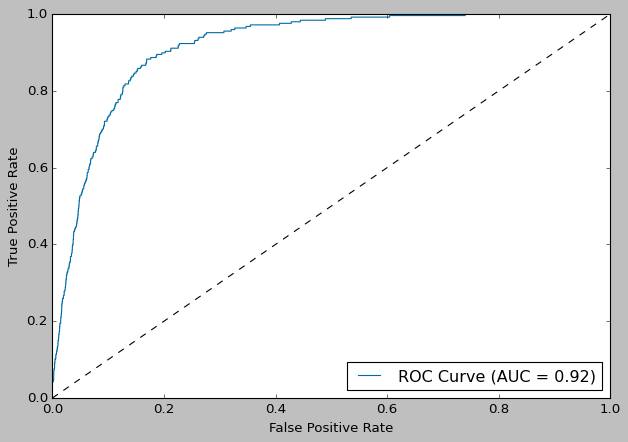

In [ ]:
from sklearn.metrics import classification_report, accuracy_score, balanced_accuracy_score, roc_curve

from sklearn.metrics import classification_report, balanced_accuracy_score, roc_curve, plot_roc_curve
from sklearn.metrics import confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight

plot_roc_curve(linear_SVM, X_test_tf, y_test, name="ROC Curve")
#plot_roc_curve()
plt.plot([0, 1], [0, 1], 'k--') 
plt.show()

In [ ]:
print(confusion_matrix(y_test, y_pred))

[[61765 24339]
 [   12   235]]


====
Precision vs Recall
====


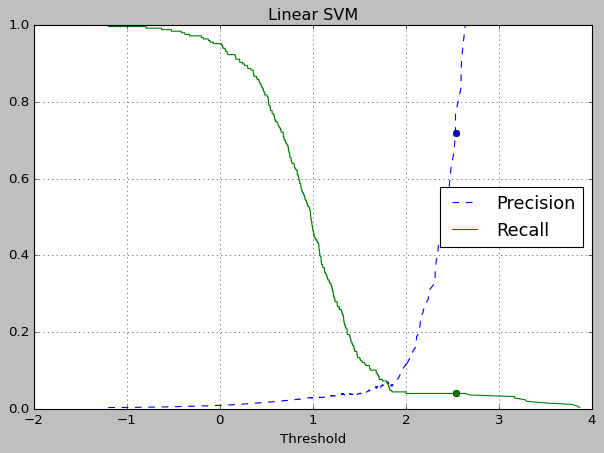

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
  plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
  plt.plot(thresholds, recalls[:-1], "g-", label="Recall")

y_scores = linear_SVM.decision_function(X_test_tf)
precisions, recalls, thresholds = precision_recall_curve(y_test, y_scores)
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

ml_score = linear_SVM.score(X_test_tf, y_test)

recall_ml_precision = recalls[np.argmax(precisions >= ml_score)]
threshold_ml_precision = thresholds[np.argmax(precisions >= ml_score)]

plt.plot([threshold_ml_precision], [recall_ml_precision], 'go')
plt.plot([threshold_ml_precision], [ml_score], 'bo')
plt.legend(loc="center right", fontsize=16)
plt.xlabel("Threshold", fontsize=12)
plt.title("Linear SVM")
plt.grid(True)

print("====")
print("Precision vs Recall")
print("====")
plt.show()

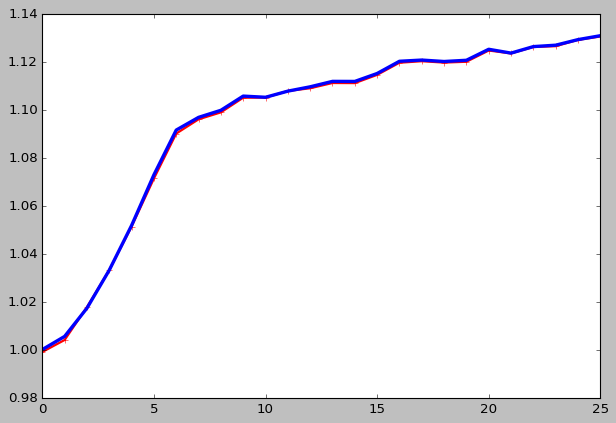

In [ ]:
from sklearn.metrics import hinge_loss

train_errors, val_errors = [], []
for m in range(1000, X_train_tf.shape[0], 10000):
    linear_SVM.fit(X_train_tf[:m], y_train[:m]) # DO NOT DELETE
    y_train_predict = linear_SVM.predict(X_train_tf[:m])
    y_val_predict = linear_SVM.predict(X_test_tf[:m])
    train_errors.append(hinge_loss(y_train[:m], y_train_predict))
    val_errors.append(hinge_loss(y_test[:m], y_val_predict))
    
plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
plt.show()

###3.5.4. Threshold analysis
Calculating model performance with alternative thresholds

In [ ]:
thresholds[np.argmax(recalls<0.5)]

0.9451861304295617

In [ ]:
from sklearn.metrics import precision_score, recall_score

y_test_pred_recall_75 = (y_scores >= thresholds[np.argmax(recalls<=0.5)])
print("precision:", precision_score(y_test, y_test_pred_recall_75))
print("recall:", recall_score(y_test, y_test_pred_recall_75))
print(confusion_matrix(y_test, y_test_pred_recall_75))

precision: 0.027683997299122215
recall: 0.4979757085020243
[[85618  4320]
 [  124   123]]


##3.6. Model 3 - Random Forest

###3.6.1. Sample Data
**Sample Data**

In [ ]:
non_billboard = data[data[label]==0]
billboard     = data[data[label]==1]

In [ ]:
nb_sampled   = non_billboard.sample(1000)
nb_unsampled = non_billboard.drop(nb_sampled.index)
b_sampled    = billboard
print(nb_sampled.shape, nb_unsampled.shape, b_sampled.shape)

(1000, 46) (343418, 46) (985, 46)


In [ ]:
data_sampled = pd.concat([b_sampled, nb_sampled])
data_sampled.shape

(1985, 46)

###3.6.2. Add Features
**Add Features**

In [ ]:
def addFeats (data, num_features, label):
  Y = data[label]
  # X = data[num_features]
  X = data[num_features+cat_features]
  num_features_add = num_features+[]
  # l = len(num_features)
  # for i1 in range(0,l):
  #   f1 = num_features[i1]
  #   for i2 in range(i1+1,l):
  #     f2 = num_features[i2]
  #     # for add
  #     newname = "_".join([f1,f2])
  #     X[newname] = X[f1]+X[f2]
  #     num_features_add.append(newname)
  #     # for multiply
  #     newname = ".".join([f1,f2])
  #     X[newname] = X[f1]*X[f2]
  #     num_features_add.append(newname)
  return X, Y, num_features_add

In [ ]:
X_feat_add, Y, num_features_add = addFeats(data_sampled, num_features, label)

In [ ]:
Y.sum()

985

In [ ]:
X_feat_add.head()

,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,acousticness,valence,release_year,release_month,release_day,release_week,key,mode,time_signature,pop,rock,rap,hip hop,country,k-pop,children,dance,electronic,alternative,acoustic,edm,latin,reggae,folk,modern,blues,jazz,soul,r&b
0,0.867,251440,0.857,0.001710,0.130,-5.892,0.0663,130.048,0.13000,0.402,2009,1,1,1,A,Major,4.0,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
1,0.743,289133,0.766,0.000000,0.509,-6.375,0.0265,127.960,0.08730,0.610,2009,1,1,1,C,Major,4.0,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
2,0.597,257560,0.517,0.000000,0.307,-6.963,0.3650,92.035,0.17900,0.412,2009,1,1,1,C,Major,4.0,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
3,0.798,284373,0.629,0.000022,0.324,-6.857,0.0735,130.000,0.00474,0.400,2009,1,1,1,B,Minor,4.0,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False
4,0.715,268840,0.907,0.000084,0.426,-6.025,0.0993,124.992,0.01720,0.841,2009,1,1,1,G,Minor,4.0,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False


In [ ]:
X_feat_add_unsamp, Y_unsamp, num_features_add_unsamp = addFeats(nb_unsampled, num_features, label)

In [ ]:
print(X_feat_add_unsamp.shape)

(343418, 37)


###3.6.3. Scale Data
**Scale Data**

In [ ]:
numeric_pipeline = Pipeline([('std_scaler', StandardScaler())])
full_pipeline    = ColumnTransformer([("num", numeric_pipeline, num_features_add),
                                      ("cat", OneHotEncoder(handle_unknown='ignore'), cat_features)
                                      ])

fp               = full_pipeline.fit(X_feat_add)
X_scaled         = fp.transform(X_feat_add)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled,Y,test_size=0.2,stratify=Y)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(1588, 180) (1588,)
(397, 180) (397,)


In [ ]:
print(y_train.sum(),y_test.sum())

788 197


In [ ]:
X_scaled_unsamp = fp.transform(X_feat_add_unsamp)

In [ ]:
testX           = pd.DataFrame.sparse.from_spmatrix(X_test)
testX_unsampled = pd.DataFrame.sparse.from_spmatrix(X_scaled_unsamp)
X_test_w_unsamp = pd.concat([testX, testX_unsampled])
y_test_w_unsamp = pd.concat([y_test, Y_unsamp])

In [ ]:
print(X_test_w_unsamp.shape,y_test_w_unsamp.shape)

(343815, 180) (343815,)


###3.6.4. Training the model
**Training the model**

In [ ]:
classifier = RandomForestClassifier(n_estimators=1600,max_depth=60)

In [ ]:
classifier.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

#### Full Data set

In [ ]:
classifier.fit(X_train_tf, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=60, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1600,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
y_pred      = classifier.predict(X_test_tf)
y_pred_prob = classifier.predict_proba(X_test_tf)

###3.6.5. Testing model
**Testing the model**

In [ ]:
y_pred      = classifier.predict(X_test)
y_pred_prob = classifier.predict_proba(X_test)

ValueError: ignored

In [ ]:
print(y_test.shape, y_pred_prob.shape)

(397,) (397, 2)


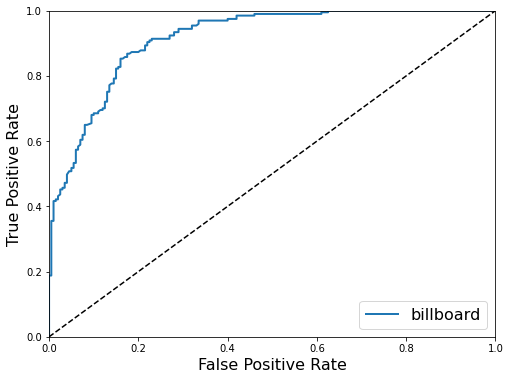

In [ ]:
plt.figure(figsize=(8,6))
fpr, tpr, thresholds = roc_curve(y_test,y_pred_prob[:,1])
plt.plot(fpr, tpr, linewidth=2, label=label)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.84      0.84       200
           1       0.84      0.85      0.84       197

    accuracy                           0.84       397
   macro avg       0.84      0.84      0.84       397
weighted avg       0.84      0.84      0.84       397



In [ ]:
print(confusion_matrix(y_test,y_pred))

[[62824 23280]
 [    9   238]]


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob[:,1])

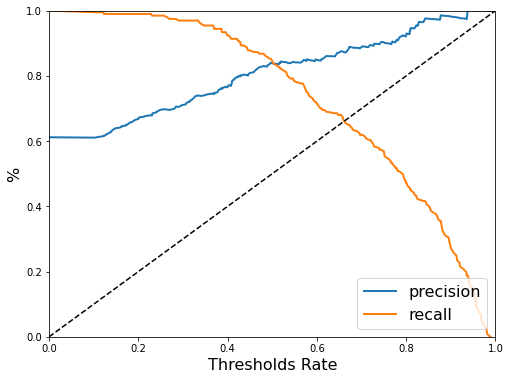

In [ ]:
plt.figure(figsize=(8,6))
plt.plot([0]+list(thresholds), precision, linewidth=2, label="precision")
plt.plot([0]+list(thresholds), recall, linewidth=2, label="recall")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('Thresholds Rate', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.show()

#### Testing on all data

In [ ]:
y_pred_w_unsamp      = classifier.predict(X_test_w_unsamp.fillna(value=0))
y_pred_prob_w_unsamp = classifier.predict_proba(X_test_w_unsamp.fillna(value=0))

In [ ]:
print(y_test_w_unsamp.shape, y_pred_prob_w_unsamp.shape)

(343696,) (343696, 2)


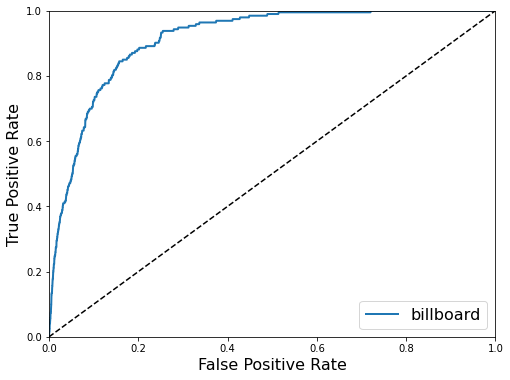

In [ ]:
plt.figure(figsize=(8,6))
fpr, tpr, thresholds = roc_curve(y_test_w_unsamp,y_pred_prob_w_unsamp[:,1])
plt.plot(fpr, tpr, linewidth=2, label=label)
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.show()

In [ ]:
plot_roc_curve(classifier, X_test_w_unsamp.fillna(value=0), y_test_w_unsamp, name="ROC Curve")
plt.plot([0, 1], [0, 1], 'k--') 
plt.show()

In [ ]:
print(classification_report(y_test_w_unsamp,y_pred_w_unsamp))
print(confusion_matrix(y_test_w_unsamp,y_pred_w_unsamp))

              precision    recall  f1-score   support

           0       1.00      0.83      0.91    343503
           1       0.00      0.85      0.01       193

    accuracy                           0.83    343696
   macro avg       0.50      0.84      0.46    343696
weighted avg       1.00      0.83      0.91    343696

[[284934  58569]
 [    29    164]]


In [ ]:
precision, recall, thresholds = precision_recall_curve(y_test_w_unsamp,y_pred_prob_w_unsamp[:,1])

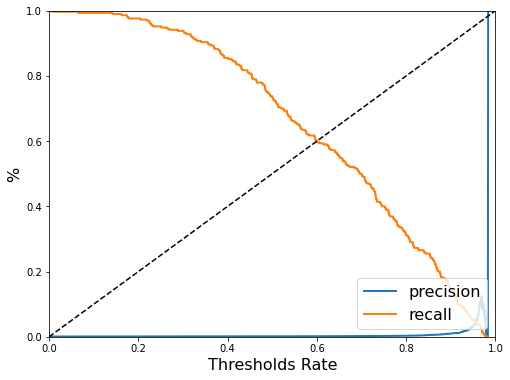

In [ ]:
plt.figure(figsize=(8,6))
plt.plot([0]+list(thresholds), precision, linewidth=2, label="precision")
plt.plot([0]+list(thresholds), recall, linewidth=2, label="recall")
plt.plot([0, 1], [0, 1], 'k--')
plt.axis([0, 1, 0, 1])
plt.xlabel('Thresholds Rate', fontsize=16)
plt.ylabel('%', fontsize=16)
plt.legend(loc="lower right", fontsize=16)
plt.show()

#### Checking feature importance

In [ ]:
importances = np.array(classifier.feature_importances_)
print(len(importances))
sorted_idx = importances.argsort()

179


In [ ]:
ohe = OneHotEncoder()
ohe.fit(X_feat_add[cat_features])
ohe_names = list(ohe.get_feature_names(cat_features))
len(ohe_names)

169

In [ ]:
input_names = np.array(num_features_add + ohe_names)
len(input_names)

179

In [ ]:
# sorted
sort_input_names = input_names[sorted_idx]
sort_importances = importances[sorted_idx]

In [ ]:
print(sorted_idx)
print(sort_input_names[:10])
print(sort_importances[:10])

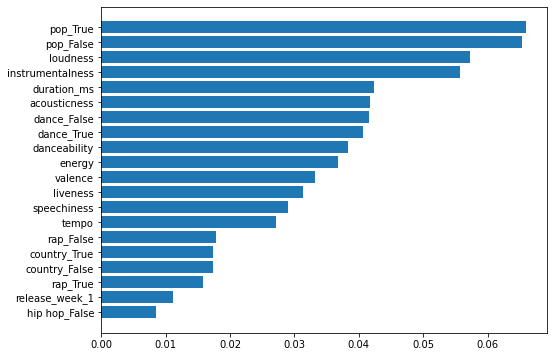

In [ ]:
drawrank_top = 20
# highest are towards the end
plt.figure(figsize=(8,6))
plt.barh(sort_input_names[-drawrank_top:], \
         sort_importances[-drawrank_top:])
plt.show()

#### Learning Curve

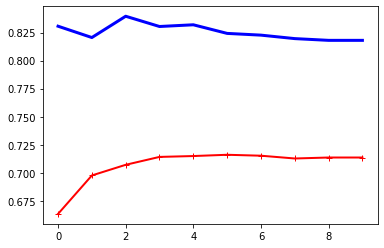

In [ ]:
from sklearn.metrics import hinge_loss
c = RandomForestClassifier(n_estimators=1600,max_depth=60)
train_errors, val_errors = [], []
for m in range(100, 2000, 200):
    c.fit(X_train[:m], y_train[:m]) # DO NOT DELETE
    y_train_predict = c.predict(X_train[:m])
    y_val_predict = c.predict(X_test[:m])
    train_errors.append(hinge_loss(y_train[:m], y_train_predict))
    val_errors.append(hinge_loss(y_test[:m], y_val_predict))
    
plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
plt.show()

###3.6.6. 2020 results
**Inspecting results for 2020**

In [ ]:
d20 = master[master["year"]==2020]
d20.info()

In [ ]:
d20.head()

,track_id,title,artist_name,year,release_year,release_month,release_day,release_week,billboard,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,number,popularity,speechiness,tempo,time_signature,acousticness,valence,genres,pop,rock,rap,hip hop,country,k-pop,children,dance,electronic,alternative,acoustic,edm,latin,reggae,folk,modern,blues,jazz,soul,r&b,ever been on billboard
49,14wf185UxfNbSy8dwt4r4q,MAMACITA,Black Eyed Peas,2020,2020,4,10,44,0,0.894,249143,0.635,0.001050,D,0.0823,-6.929,Major,-1,83,0.0473,105.013,4.0,0.1930,0.428,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,1.0
50,0pGC7cwCOakpvCFYiawNhM,FEEL THE BEAT,Black Eyed Peas,2020,2020,6,19,1,0,0.896,237714,0.528,0.000189,C,0.7730,-5.981,Minor,-1,71,0.0849,104.991,4.0,0.1140,0.312,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,1.0
51,6c6Pr4ALb2SD7j7UnS5YDE,VIDA LOCA,Black Eyed Peas,2020,2020,6,19,22,0,0.885,234375,0.618,0.000022,A#/B♭,0.3250,-5.705,Minor,-1,73,0.0544,127.983,4.0,0.0225,0.769,dance pop_pop_pop dance_pop rap,True,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,1.0
138,62hTXlVQacy3pjBW4ntRPl,1000 Doves,Lady Gaga,2020,2020,5,29,52,0,0.668,215480,0.826,0.000011,A,0.4740,-4.466,Major,-1,67,0.0383,122.973,4.0,0.0236,0.388,dance pop_pop_pop dance,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0.0
139,6qI0MU175Dk2DeoUjlrOpy,911,Lady Gaga,2020,2020,5,29,53,0,0.789,172133,0.813,0.000002,F,0.5190,-4.563,Major,-1,79,0.0374,116.007,4.0,0.0294,0.420,dance pop_pop_pop dance,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,0.0


In [ ]:
X_d20, Y_d20, num_features_add_d20 = addFeats(d20, num_features, label)

In [ ]:
X_d20_scaled = fp.transform(X_d20)

In [ ]:
y_d20_pred = classifier.predict(X_d20_scaled)
y_d20_pred_proba = classifier.predict_proba(X_d20_scaled)

#### Better odds than not

In [ ]:
d20_yes = d20[y_d20_pred == 1]

In [ ]:
d20_yes.shape

(3898, 46)

In [ ]:
d20_yes[['title','artist_name']].head()

,title,artist_name
49,MAMACITA,Black Eyed Peas
50,FEEL THE BEAT,Black Eyed Peas
51,VIDA LOCA,Black Eyed Peas
138,1000 Doves,Lady Gaga
139,911,Lady Gaga


#### Those with highest probability

In [ ]:
print(X_d20.shape,pd.DataFrame(y_d20_pred_proba[:,1]).shape)

(15105, 37) (15105, 1)


In [ ]:
name_prob = d20[['title','artist_name']]
name_prob['prob'] = pd.DataFrame(y_d20_pred_proba[:,1])
name_prob.shape

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


(15105, 3)

In [ ]:
name_prob.head()

,title,artist_name,prob
49,MAMACITA,Black Eyed Peas,0.812500
50,FEEL THE BEAT,Black Eyed Peas,0.948125
51,VIDA LOCA,Black Eyed Peas,0.876875
138,1000 Doves,Lady Gaga,0.603750
139,911,Lady Gaga,0.559375


In [ ]:
name_prob.sort_values(by=['prob'], ascending=False).head()

,title,artist_name,prob
764,On The Hood (feat. 42 Dugg & Mozzy),T.I.,0.975000
1028,I Believe That We Will Win (World Anthem) - Th...,Pitbull,0.972500
766,Hit Dogs Holla,T.I.,0.965625
4027,Next To You,Bryson Tiller,0.957500
769,Respect The Code (feat. Kes Kross),T.I.,0.952500


In [ ]:
name_prob.to_csv("/content/drive/MyDrive/Studies/ML/ML Group Project/Data Sets/rf_prob_pred_2020.csv")

###3.6.*. STEP E1 *
**Hyperparameter Tuning**

Technically this is done very early into the iteration but since this does not need to be repeated all the time and takes a lot of time, this is kept separate.

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, verbose=2)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [ ]:
def evaluate(model, X_test, y_test):
  predictions = model.predict(X_test)
  c = confusion_matrix(y_test,predictions)
  print(accuracy_score(y_test,predictions))
  pprint(c)
  return c

In [ ]:
base_model = RandomForestClassifier(n_estimators = 10)
base_model.fit(X_train, y_train)
base_accuracy = evaluate(base_model, X_test, y_test)

0.7389830508474576
array([[233,  67],
       [ 87, 203]])


In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, X_test, y_test)

0.7762711864406779
array([[233,  67],
       [ 65, 225]])


In [ ]:
pprint(rf_random.best_params_)

{'bootstrap': True,
 'max_depth': 60,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1600}


# 4.0 Common Results

##4.1. ROC_AUC Plot Curves

In [ ]:
log_disp = plot_roc_curve(log_reg, X_test_tf, y_test, name="Logistic Reg")
svm_disp = plot_roc_curve(linear_SVM, X_test_tf, y_test, name="Linear SVM", ax=log_disp.ax_)
fin_disp = plot_roc_curve(classifier, X_test_tf, y_test, name="Random Forest", ax=svm_disp.ax)

plt.show()

##4.2. 2020 Songs Predictions

In [ ]:
data_2020=pd.read_csv('/content/drive/MyDrive/ML Group Project/Data Sets/dataset_2020.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)

In [ ]:
data_2020.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 46 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   track_id                42 non-null     object 
 1   title                   42 non-null     object 
 2   artist_name             42 non-null     object 
 3   year                    42 non-null     int64  
 4   release_year            42 non-null     int64  
 5   release_month           42 non-null     int64  
 6   release_day             42 non-null     int64  
 7   release_week            42 non-null     int64  
 8   danceability            42 non-null     float64
 9   duration_ms             42 non-null     int64  
 10  energy                  42 non-null     float64
 11  instrumentalness        42 non-null     float64
 12  key                     42 non-null     object 
 13  liveness                42 non-null     float64
 14  loudness                42 non-null     floa

In [ ]:
X_2020=data_2020.drop(remaining_features,axis=1)
# X_2020=X_2020.drop(label,axis=1)

In [ ]:
X_train.info(), X_2020.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 259052 entries, 339576 to 259191
Data columns (total 38 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   release_year            259052 non-null  int64  
 1   release_month           259052 non-null  int64  
 2   release_day             259052 non-null  int64  
 3   release_week            259052 non-null  int64  
 4   danceability            259052 non-null  float64
 5   duration_ms             259052 non-null  int64  
 6   energy                  259052 non-null  float64
 7   instrumentalness        259052 non-null  float64
 8   key                     259052 non-null  object 
 9   liveness                259052 non-null  float64
 10  loudness                259052 non-null  float64
 11  mode                    259052 non-null  object 
 12  speechiness             259052 non-null  float64
 13  tempo                   259052 non-null  float64
 14  time_signature 

(None, None)

In [ ]:
X_2020_tf = fp.transform(X_2020)

y_2020 = log_reg.predict(X_2020_tf)

In [ ]:
data_2020[y_2020==0][['title','artist_name','pop']]

,title,artist_name,pop
0,Watermelon Sugar,Harry Styles,True
3,ily (i love you baby) (feat. Emilee),Surf Mesa,False
4,Before You Go,Lewis Capaldi,True
9,Adore You,Harry Styles,True
11,Roses - Imanbek Remix,SAINt JHN,True
12,Say So,Doja Cat,True
13,If the World Was Ending - feat. Julia Michaels,JP Saxe,True
17,Breaking Me,Topic,True
18,Falling,Trevor Daniel,True
19,Circles,Post Malone,False
